# BBPSSW Protocol 

In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from qutip.measurement import measure_povm

In [2]:
phi_plus = bell_state("00")
phi_minus = bell_state("01")
psi_plus = bell_state("10")
psi_minus = bell_state("11")

def werner_state(F):
    # """
    # Returns a Werner state with fidelity F (with respect to psi_minus).
    # """
    if F < 0 or F > 1:
        raise Exception("Fidelity must be between 0 and 1.")
    state = F * psi_minus * psi_minus.dag() + (1 - F) / 3 * (phi_plus * phi_plus.dag() + phi_minus * phi_minus.dag() + psi_plus * psi_plus.dag())
    return state

In [3]:
#FUNCTION TO CHECK IF A STATE IS A WERNER STATE

def check_werner_r1(rho, tol=1e-6):
    """
    Check whether a 4x4 matrix rho corresponds to the Werner-type state:
    rho_W = r1 * |1><1| + (1-r1)/3 * (I4 - |1><1|)
    where |1> = (|01> - |10>)/sqrt(2).
    In the computational basis {|00>, |01>, |10>, |11>}, the matrix form is:
    rho_W = [[(1-r1)/3, 0, 0, 0],
    [0, (2*r1+1)/6, (1-4*r1)/6, 0],
    [0, (1-4*r1)/6, (2*r1+1)/6, 0],
    [0, 0, 0, (1-r1)/3]]
    Parameters
    ----------
    rho : 2D numpy array (shape (4,4))
    The density matrix to test.
    tol : float
    Numerical tolerance for consistency checks.
    Returns
    -------
    (is_werner, r1_value)
    is_werner : bool
    True if all derived r1 values match within 'tol'.
    r1_value : float or None
    The average r1 if consistent, else None.
    """

    # Corner diagonals (should be (1-r1)/3):

    corner_val = rho[0, 0] # same as rho[3,3] ideally

    # Center diagonals (should be (2*r1 + 1)/6):

    center_diag_val = rho[1, 1] # same as rho[2,2] ideally

    # Off-diagonals in the center block (should be (1 - 4*r1)/6):

    center_offdiag_val = rho[1, 2] # same as rho[2,1] ideally

    # Solve for r1 from each expression:

    # 1) corner_val = (1 - r1)/3 => r1 = 1 - 3 * corner_val

    r1_corner = 1.0 - 3.0 * corner_val

    # 2) center_diag_val = (2*r1 + 1)/6 => 2*r1 + 1 = 6*center_diag_val => r1 = 3*center_diag_val - 0.5

    r1_center_diag = 3.0 * center_diag_val - 0.5

    # 3) center_offdiag_val = (1 - 4*r1)/6 => 1 - 4*r1 = 6*center_offdiag_val => r1 = (1 - 6*center_offdiag_val)/4

    r1_center_offdiag = (1.0 - 6.0 * center_offdiag_val) / 4.0

    # Put them all in a list

    r1_candidates = [r1_corner, r1_center_diag, r1_center_offdiag]

    # Check if they are all close within 'tol'
    if (np.allclose(r1_corner, r1_center_diag, atol=tol) and np.allclose(r1_corner, r1_center_offdiag, atol=tol)):

        # If consistent, return average

        r1_mean = np.mean(r1_candidates)
        return True, r1_mean
    else:
    # Not consistent -> not a Werner state of this specific form
        return False, None



In [4]:
def unilateral_y_rotation(state):
    #create custom unilateral y-rotation operators
    u_rotation_qubit0 = tensor(sigmay(), qeye(2), qeye(2), qeye(2))
    u_rotation_qubit2 = tensor(qeye(2), qeye(2), sigmay(), qeye(2))

    #apply unilateral y-rotation on qubit 0 and 2 
    state = u_rotation_qubit0 * state * u_rotation_qubit0.dag()
    state = u_rotation_qubit2 * state * u_rotation_qubit2.dag()
    return state

def bilateral_xor(rho):
    #define zero and one basis for our 4-qubit system
    zero_state = basis(2,0) * basis(2,0).dag()
    one_state = basis(2,1) * basis(2,1).dag()

    #generate bxor operators for different operators
    bxor02 = tensor(zero_state, qeye(2), qeye(2), qeye(2)) + tensor(one_state, qeye(2), sigmax(), qeye(2))
    bxor13 = tensor(qeye(2), zero_state, qeye(2), qeye(2)) + tensor(qeye(2), one_state, qeye(2), sigmax())

    # #generate bxor operators for different operators
    # bxor02 = tensor(zero_state, qeye(2), qeye(2), qeye(2)) + tensor(one_state, qeye(2), sigmax(), qeye(2))
    # bxor13 = tensor(qeye(2), zero_state, qeye(2), qeye(2)) + tensor(qeye(2), one_state, sigmax(), qeye(2))

    rho = bxor02 * rho * bxor02.dag()
    rho = bxor13 * rho * bxor13.dag()
    return rho

def measure_qubits(state):
    Z0 = ket2dm(basis(2, 0))
    Z1 = ket2dm(basis(2, 1))
    # The measurement POVM elements act as identity on qubits 0 and 1:
    PZ = [
        tensor(qeye(2), qeye(2), Z0, Z0),
        tensor(qeye(2), qeye(2), Z1, Z1),
        tensor(qeye(2), qeye(2), Z0, Z1),
        tensor(qeye(2), qeye(2), Z1, Z0)
    ]
    
    outcome, final = measure_povm(state, PZ)
    return outcome, final

In [5]:

def bbpssw(input_fidelity):
    # print("Final Fidelity:", input_fidelity)
    werner_input = werner_state(input_fidelity)
    rho = tensor(werner_input,werner_input)
    
    #START PURIFICATION PROCESS``
    #apply unilateral y-rotation on qubit 0 and 2
    rho = unilateral_y_rotation(rho)

    #apply bilateral xor on qubits (0,2) and (1,3)
    rho = bilateral_xor(rho)

    #measure target qubits 2 and 3, keep 
    measurement_result, rho_post =  measure_qubits(rho)
    
    #check for successful purification
    if measurement_result in [0,1]:
        purified_state = rho_post.ptrace([0,1])

        y_rotation = tensor(sigmay(), qeye(2))
        purified_state = y_rotation * purified_state * y_rotation.dag()

        output_fidelity = fidelity(purified_state, bell_state("11"))
        output_fidelity_squared = output_fidelity * output_fidelity
        # print("Final Fidelity:", output_fidelity_squared)
        return purified_state, output_fidelity_squared
    # else:
    #     # print("Purification Failed")
    return None, None

bbpssw(0.7)


(Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[ 0.02941176  0.          0.          0.        ]
  [ 0.          0.47058824 -0.26470588  0.        ]
  [ 0.         -0.26470588  0.47058824  0.        ]
  [ 0.          0.          0.          0.02941176]],
 np.float64(0.7352941176470591))

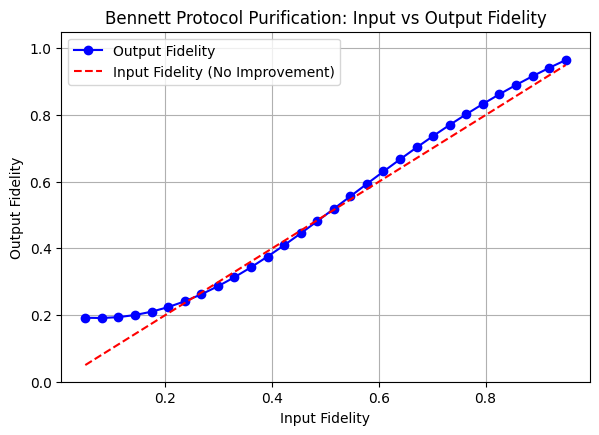

Mean improvement in fidelity:  0.0384818718576157
Standard Dev:  0.03634634101971073
Success Probability 0.6196934865900382


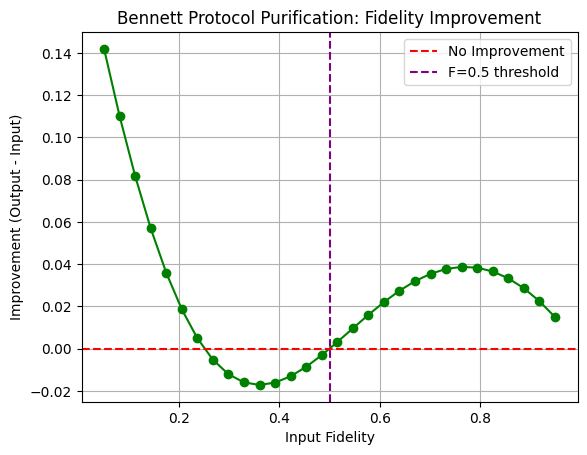

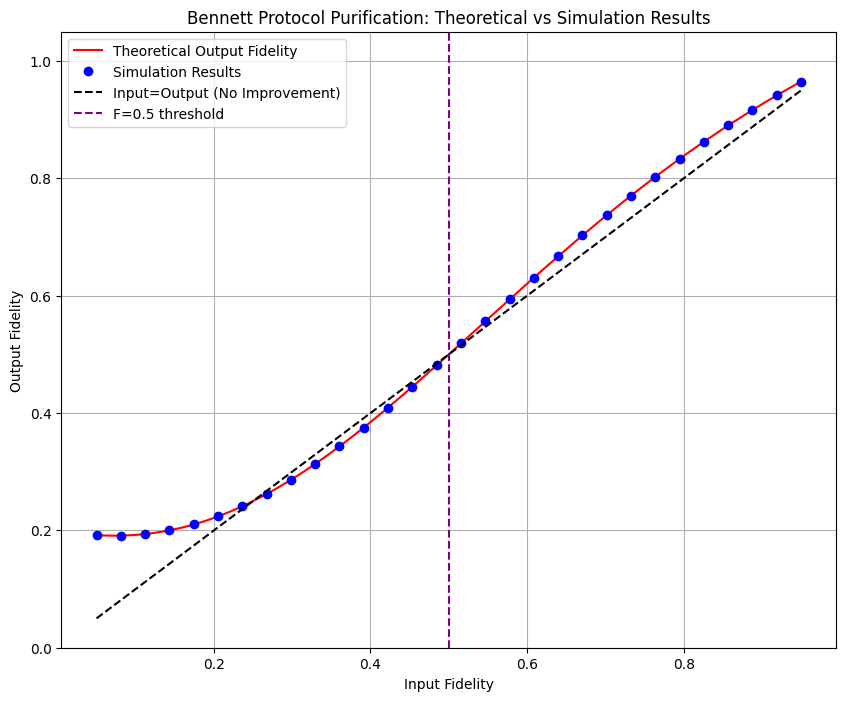

Summary of BBPSSW Purification Results:
----------------------------------------
F=0.5 is the theoretical threshold for purification to work
Input F: 0.050, Output F: 0.192, Improvement: 0.142, Success Prob: 0.536
Input F: 0.081, Output F: 0.191, Improvement: 0.110, Success Prob: 0.525
Input F: 0.112, Output F: 0.194, Improvement: 0.082, Success Prob: 0.517
Input F: 0.143, Output F: 0.200, Improvement: 0.057, Success Prob: 0.510
Input F: 0.174, Output F: 0.210, Improvement: 0.036, Success Prob: 0.505
Input F: 0.205, Output F: 0.224, Improvement: 0.019, Success Prob: 0.502
Input F: 0.236, Output F: 0.241, Improvement: 0.005, Success Prob: 0.500
Input F: 0.267, Output F: 0.262, No improvement: -0.005, Success Prob: 0.500
Input F: 0.298, Output F: 0.286, No improvement: -0.012, Success Prob: 0.502
Input F: 0.329, Output F: 0.313, No improvement: -0.016, Success Prob: 0.506
Input F: 0.360, Output F: 0.343, No improvement: -0.017, Success Prob: 0.511
Input F: 0.391, Output F: 0.375, No impr

: 

In [ ]:
def calculate_success_probability(input_fidelity):
    """Calculate the theoretical success probability for BBPSSW purification."""
    F = input_fidelity
    return F**2 + (5*(1-F)**2)/9 + (2*F*(1-F))/3

# Generate data for the plot - start from 0.05 instead of 0.5
input_fidelities = np.linspace(0.05, 0.95, 30)
output_fidelities = []
improvements = []
success_probabilities = []

# For each input fidelity, perform the purification and record results
for F_in in input_fidelities:
    _, F_out = bbpssw(F_in)
    
    # If purification was successful, record the improvement
    if F_out is not None:
        output_fidelities.append(F_out)
        improvements.append(F_out - F_in)
        success_prob = calculate_success_probability(F_in)
        success_probabilities.append(success_prob)
    else:
        # Retry a few times in case we got unlucky with the measurement outcomes
        for _ in range(5):
            _, F_out = bbpssw(F_in)
            if F_out is not None:
                output_fidelities.append(F_out)
                improvements.append(F_out - F_in)
                success_prob = calculate_success_probability(F_in)
                success_probabilities.append(success_prob)
                break
        else:
            # If all retries failed, append None
            output_fidelities.append(None)
            improvements.append(None)
            success_probabilities.append(None)

# Remove any None entries from the data
valid_indices = [i for i, val in enumerate(output_fidelities) if val is not None]
valid_inputs = [input_fidelities[i] for i in valid_indices]
valid_outputs = [output_fidelities[i] for i in valid_indices]
valid_improvements = [improvements[i] for i in valid_indices]
valid_success_probs = [success_probabilities[i] for i in valid_indices]

# Create the plots
plt.figure(figsize=(15, 10))

# Plot 1: Input vs Output Fidelity
plt.subplot(2, 2, 1)
plt.plot(valid_inputs, valid_outputs, 'bo-', label='Output Fidelity')
plt.plot(valid_inputs, valid_inputs, 'r--', label='Input Fidelity (No Improvement)')
plt.xlabel('Input Fidelity')
plt.ylabel('Output Fidelity')
plt.title('Bennett Protocol Purification: Input vs Output Fidelity')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)  # Set y-axis limits for fidelity
# plt.savefig('plots/bbpssw/bbpsswInputVOuput.svg', dpi=300)
plt.show()

# Plot 2: Input Fidelity vs Improvement
# plt.subplot(2, 2, 2)
import statistics
from math import fsum

sum = 0
count = 0
for value in valid_improvements:
    if value > 0:
        sum = sum + value
        count = count+1

print("Mean improvement in fidelity: ", sum/count)
print("Standard Dev: ", statistics.stdev(valid_improvements))
# print(fsum(valid_success_probs))
print("Success Probability", (fsum(valid_success_probs)/len(valid_success_probs)))

plt.plot(valid_inputs, valid_improvements, 'go-')
plt.xlabel('Input Fidelity')
plt.ylabel('Improvement (Output - Input)')
plt.title('Bennett Protocol Purification: Fidelity Improvement')
plt.axhline(y=0, color='r', linestyle='--', label='No Improvement')
plt.legend()
plt.grid(True)
plt.axvline(x=0.5, color='purple', linestyle='--', label='F=0.5 threshold')
plt.legend()

plt.savefig('plots/bbpssw/bbpsswKarthik_purification_plots_extended.svg', dpi=400)
plt.show()

# Add additional theoretical curve for comparison
F_theory = np.linspace(0.05, 0.95, 100)

def bbpssw_theoretical_output(F):
    # Calculate the numerator and denominator separately
    numerator = F**2 + (1/9) * (1 - F)**2
    denominator = F**2 + (2/3) * F * (1 - F) + (5/9) * (1 - F)**2
    
    # Calculate F'
    F_prime = numerator / denominator
    
    return F_prime

# Plot theoretical vs experimental curves
plt.figure(figsize=(10, 8))
theory_outputs = [bbpssw_theoretical_output(f) for f in F_theory]
plt.plot(F_theory, theory_outputs, 'r-', label='Theoretical Output Fidelity')
plt.plot(valid_inputs, valid_outputs, 'bo', label='Simulation Results')
plt.plot(F_theory, F_theory, 'k--', label='Input=Output (No Improvement)')
plt.axvline(x=0.5, color='purple', linestyle='--', label='F=0.5 threshold')
plt.xlabel('Input Fidelity')
plt.ylabel('Output Fidelity')
plt.title('Bennett Protocol Purification: Theoretical vs Simulation Results')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)
plt.savefig('plots/bbpssw/bbpsswKarthik_theoretical_v_simulation.svg', dpi=300)
plt.show()

# Print a summary of results
print("Summary of BBPSSW Purification Results:")
print("----------------------------------------")
print("F=0.5 is the theoretical threshold for purification to work")
for i, f_in in enumerate(valid_inputs):
    imp_status = "Improvement" if valid_improvements[i] > 0 else "No improvement"
    print(f"Input F: {f_in:.3f}, Output F: {valid_outputs[i]:.3f}, "
          f"{imp_status}: {valid_improvements[i]:.3f}, Success Prob: {valid_success_probs[i]:.3f}")